**Project 3: Web APIs & Classification Part 2 - Data cleaning / Models**

# Problem statement

Using data obtained from webscraping, to train a classifier to predict which subreddit a given post came from.

I will be scraping data from www.reddit.com. 2 subreddit will be selected and 1000 posts(each) will be scraped. The data from the post will then be fed to classifier models for training and to used to predict the subreddit which the testing post is from. 

##### Importing relevant libraries.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.ensemble import VotingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
import re
%matplotlib inline

# Data Cleaning

## Importing data

In [2]:
df_parenting=pd.read_csv('../datasets/parenting.csv') #reading csv file

In [3]:
df_childfree=pd.read_csv('../datasets/childfree.csv') #reading csv file

In [4]:
df_childfree.head()

title  \
0            future mommies get to skip the line !!!   
1                Getting a vasectomy in the UK (M21)   
2  Apparently you only have the right to have you...   
3        I see ads for young parents All. The. Time.   
4  "If you get pregnant this year, it will improv...   

                                            selftext       type  
0  my new potential workplace - a chain store wit...  childfree  
1  Hi all,\n\nSorry for the upfront post but I've...  childfree  
2  So this happened a few minutes ago:\nWhile hav...  childfree  
3  I clicked on the "why do I see this ad?" optio...  childfree  
4  My husband and I have been married for less th...  childfree

**Changing the target to 0 for childfree and 1 for parenting.**

In [5]:
df_childfree['type']=0 

In [6]:
df_childfree.head()

title  \
0            future mommies get to skip the line !!!   
1                Getting a vasectomy in the UK (M21)   
2  Apparently you only have the right to have you...   
3        I see ads for young parents All. The. Time.   
4  "If you get pregnant this year, it will improv...   

                                            selftext  type  
0  my new potential workplace - a chain store wit...     0  
1  Hi all,\n\nSorry for the upfront post but I've...     0  
2  So this happened a few minutes ago:\nWhile hav...     0  
3  I clicked on the "why do I see this ad?" optio...     0  
4  My husband and I have been married for less th...     0

In [7]:
df_childfree.isnull().sum() # Checking for null values.

title        0
selftext    46
type         0
dtype: int64

There are 46 null selftext values.

In [8]:
df_childfree.shape

(997, 3)

In [9]:
df_parenting.head()

title  \
0                         Thule Baby Seats for Bikes   
1  My Kids [13M-11M] are not over the moon with S...   
2  Do you think the use of technology discourages...   
3  Parents,What would you do if your child's teac...   
4  My 11 week old baby seems to be getting "bored...   

                                            selftext       type  
0  I need help deciding between the Ridealong min...  parenting  
1  I got divorce 8 years and at the begging I was...  parenting  
2  Hey everyone,\n\nWhat's your opinion on techno...  parenting  
3  \n\nParents, what would you do if a teacher de...  parenting  
4  My 11 week old can keep himself self entertain...  parenting

In [10]:
df_parenting['type']=1

In [11]:
df_parenting.head()

title  \
0                         Thule Baby Seats for Bikes   
1  My Kids [13M-11M] are not over the moon with S...   
2  Do you think the use of technology discourages...   
3  Parents,What would you do if your child's teac...   
4  My 11 week old baby seems to be getting "bored...   

                                            selftext  type  
0  I need help deciding between the Ridealong min...     1  
1  I got divorce 8 years and at the begging I was...     1  
2  Hey everyone,\n\nWhat's your opinion on techno...     1  
3  \n\nParents, what would you do if a teacher de...     1  
4  My 11 week old can keep himself self entertain...     1

In [12]:
df_parenting.isnull().sum() #Checking for null values

title       0
selftext    0
type        0
dtype: int64

In [13]:
df_parenting.shape

(993, 3)

In [14]:
df=pd.concat([df_childfree,df_parenting]) # Joining the 2 datasets 

In [15]:
df.shape

(1990, 3)

**Creating new column 'all' to combine the title and selftext**

In [16]:
df['all']=df['title']+' '+df['selftext'] 

In [17]:
df.reset_index(inplace=True)

In [18]:
df.head()

index                                              title  \
0      0            future mommies get to skip the line !!!   
1      1                Getting a vasectomy in the UK (M21)   
2      2  Apparently you only have the right to have you...   
3      3        I see ads for young parents All. The. Time.   
4      4  "If you get pregnant this year, it will improv...   

                                            selftext  type  \
0  my new potential workplace - a chain store wit...     0   
1  Hi all,\n\nSorry for the upfront post but I've...     0   
2  So this happened a few minutes ago:\nWhile hav...     0   
3  I clicked on the "why do I see this ad?" optio...     0   
4  My husband and I have been married for less th...     0   

                                                 all  
0  future mommies get to skip the line !!! my new...  
1  Getting a vasectomy in the UK (M21) Hi all,\n\...  
2  Apparently you only have the right to have you...  
3  I see ads for young parents All. The. Time. I ...  
4  "If you get pregnant this year, it will improv...

In [19]:
df.isnull().sum() 

index        0
title        0
selftext    46
type         0
all         46
dtype: int64

**Some selftext is nullvalues. This affect the result of column 'all'. To replace null values in 'all' column with the title.**

In [20]:
nullindex=df[df['all'].isnull()]['all'].index #getting the index of nullvalues in 'all' column

In [21]:
for x in nullindex:
    df.loc[x,'all']=df.loc[x,'title']

## Data Dictionary

|Feature|Type|Description|
|---|---|---|
|title|object|Title of reddit post|
|selftext|object|Main Body content of reddit post|
|type|int|Indicates which reddit the post comes from (0:childfree, 1:parenting)|
|all|object|Title and main body content of reddit post|

## Train test split

In [22]:
X=df[['all']] # column 'all' contain both title and main body content
y=df['type'] # target variable

In [23]:
# creating train test set with stratify=y to make sure we have both class in both sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,stratify=y,random_state=42) 

## Bag of words

In [24]:
#instantiate lemmatizer and stemmer
lemmatizer = WordNetLemmatizer()
p_stemmer = PorterStemmer()

**Function to return a list of words/numbers after lemmatizing and stemming and remving stopwords.**

In [25]:
def review_to_words(content):
    # Function to convert a raw review to a string of words
    # The input is a single string (title + main body post), and 
    # the output is a single string (a preprocessed title + main body post)
    
    # 1. Remove non-alphanumeric and \n
    letters_only = re.sub("[^a-zA-Z0-9]", " ", content).replace('\n', ' ')
    
    # 2. Convert to lower case, split into individual words.
    words = letters_only.lower().split()
    
    # 3. In Python, searching a set is much faster than searching
    # a list, so convert the stop words to a set.
    stops = set(stopwords.words('english'))
    stops.update(['childfree','child-free']) # Adding subject as stopwords
    
    # 4. Remove stop words, lemmatize and stem words
    meaningful_words = [lemmatizer.lemmatize(w) for w in words if not w in stops]
    meaningful_words = [p_stemmer.stem(w) for w in meaningful_words]
    
    # 5. Join the words back into one string separated by space, 
    # and return the result.
    return(" ".join(meaningful_words))

**To loop through the X_train and X_test 'all' columns to remove stopwords and to lemmarize and stem words. The words will be stored into a list of clean_train and clean_test.**

In [26]:
clean_train = [] #training set
clean_test = [] #testing set

In [27]:
for data in X_train['all']:
    # Convert review to words, then append to clean_train_title.
    clean_train.append(review_to_words(data))

for data in X_test['all']:
    # Convert review to words, then append to clean_test_title.
    clean_test.append(review_to_words(data))

# Modelling

## Baseline model

In [28]:
y_test.value_counts(normalize=True)

0    0.500838
1    0.499162
Name: type, dtype: float64

**The probability of predicting either childfree(0) or parenting(1) is around 0.5.**

I plan to use 3 types of Vectorizer -  ***CountVectorizer, TfidfVectorizer, HashingVectorizer.*** These will break down the  words and the values will then be fed through classifiers to determine which subreddit the post is from.

## CountVectorizer path

##### CountVectorizer tokenize a collection of text documents and encode each document. This return encoded vectors which are occurrence for each word. This vectors can be pushed to classifier models or machine learning algorithm.

### Tokenize data

In [29]:
cvec = CountVectorizer() #instantiate model

In [30]:
train_data_cvec = cvec.fit_transform(clean_train) #fit the model to clean_train and transform the data
test_data_cvec = cvec.transform(clean_test) #transform the data of clean_test using the same cvec
train_data_cvec = train_data_cvec.todense()# The matrix is sparse. Sparse matrices can cause problems with regards to space and time complexity. Todense() helps store the data more efficiently
test_data_cvec = test_data_cvec.todense() #Todense() helps store the data more efficiently

In [31]:
train_data_cvec.shape

(1393, 8428)

### Cross Validation

**We will be deploying 4 classifier models and using cross val score to determine which model will produce the best results.**

In [32]:
lr=LogisticRegression() 
nb = MultinomialNB() 
gb = GaussianNB()
ada = AdaBoostClassifier()

In [33]:
print(cross_val_score(lr,train_data_cvec,y_train,cv=10).mean())
print(cross_val_score(nb,train_data_cvec,y_train,cv=10).mean())
print(cross_val_score(gb,train_data_cvec,y_train,cv=10).mean())
print(cross_val_score(ada,train_data_cvec,y_train,cv=10).mean())

/Users/jiaxing/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jiaxing/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jiaxing/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jiaxing/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jiaxing/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed

0.8958971208126666
0.9102964833102462
0.7487353471260259
0.8736769590538749


**MultinomialNB gives the best accuracy. Hence we will deploy MultinomialNB to further test on our train and test data.**

In [34]:
nb.fit(train_data_cvec,y_train)
nb.score(train_data_cvec,y_train)

0.9748743718592965

In [35]:
nb.score(test_data_cvec,y_test)

0.9296482412060302

**The accuracy is high but the model is overfit to the training data.**

### GridSearch

**Performing Gridsearch to find the optimal parameters.**

In [36]:
pipe_cvec = Pipeline([
    ('cvec', CountVectorizer(analyzer = "word",
                             tokenizer = None,
                             preprocessor = None,
                             stop_words = None)),
    ('nb', MultinomialNB()),
])
pipe_params = {
    'cvec__max_features': [1000, 1500, 2500, 3000],
    'cvec__ngram_range': [(1,1), (1,2), (1,3)],
    'nb__alpha':np.linspace(2, 3, 10)
}
gs_cvec = GridSearchCV(pipe_cvec, param_grid=pipe_params, cv=10, n_jobs=-1)

**Fitting model to generate score and best params used.**

In [37]:
gs_cvec.fit(clean_train,y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('cvec',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                           

In [38]:
print(gs_cvec.best_params_)
print(gs_cvec.best_score_)

{'cvec__max_features': 2500, 'cvec__ngram_range': (1, 2), 'nb__alpha': 2.111111111111111}
0.9073941134242641


**With the best params as above, we will instantiate new model and countvectoriser.**

### Final model with CountVectorizer

In [39]:
cvec = CountVectorizer(max_features = 2500,
                           ngram_range= (1, 2))

In [40]:
train_data_cvec = cvec.fit_transform(clean_train)
test_data_cvec = cvec.transform(clean_test)
train_data_cvec = train_data_cvec.todense()
test_data_cvec = test_data_cvec.todense()

In [41]:
nb_cvec = MultinomialNB(alpha=2.111111111111111)
nb_cvec.fit(train_data_cvec,y_train)
print(nb_cvec.score(train_data_cvec,y_train))
print(nb_cvec.score(test_data_cvec,y_test))

0.9468772433596554
0.931323283082077


In [42]:
tn, fp, fn, tp=confusion_matrix(y_test, nb_cvec.predict(test_data_cvec)).ravel() #True negative, False positive, false negative and true positive

In [43]:
print(classification_report(y_test, nb_cvec.predict(test_data_cvec)))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93       299
           1       0.93      0.93      0.93       298

    accuracy                           0.93       597
   macro avg       0.93      0.93      0.93       597
weighted avg       0.93      0.93      0.93       597



In [44]:
print(f'Accuracy = {round((tp + tn) /(tn+ fp+ fn+ tp),3)}')
print(f'Misclassification Rate = {round((fp + fn) /(tn+ fp+ fn+ tp),3)}')
print(f'Sensitivity = {round(tp /(fn+ tp),3)}')
print(f'Specificity = {round(tn /(fp+ tn),3)}')
print(f'Precision = {round(tp /(fp+ tp),3)}')

Accuracy = 0.931
Misclassification Rate = 0.069
Sensitivity = 0.933
Specificity = 0.93
Precision = 0.93


**6.9% of the posts are misclassified and 93.1% of the post are correctly labelled. Due to the nature of the posts, False positive and False negative are equally bad. It may invite unneccesary comments.**

### Receiver Operating Characteristic Curve

**Ploting the ROC curve to see how the model performs compared to baseline model.**

In [45]:
pred_proba_cvec = [i[1] for i in nb_cvec.predict_proba(test_data_cvec)]

pred_df_cvec = pd.DataFrame({'true_values': y_test, # Creating Dataframe to store all the true y
                        'pred_probs':pred_proba_cvec})

In [46]:
print(roc_auc_score(y_test,pred_proba_cvec)) ## Area Under the ROC Curve

0.9738950865300442


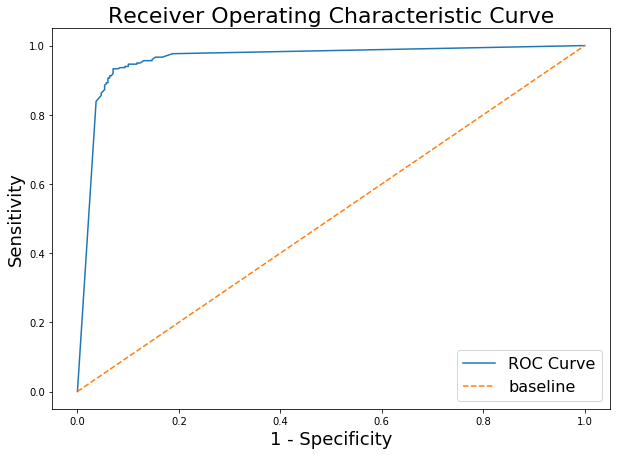

In [47]:
# Create figure.
plt.figure(figsize = (10,7))

# Create threshold values.
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] > threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)

# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values_nb_cvec = [TPR(pred_df_cvec, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values_nb_cvec = [FPR(pred_df_cvec, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values_nb_cvec, # False Positive Rate on X-axis
         tpr_values_nb_cvec, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title('Receiver Operating Characteristic Curve', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16);

**We can see that the model is performing better than the baseline model. The ROC curve shows the trade-off between sensitivity (or TPR) and specificity (1 ‚Äì FPR). Classifiers that give curves closer to the top-left corner indicate a better performance.**

#### Top 20 words

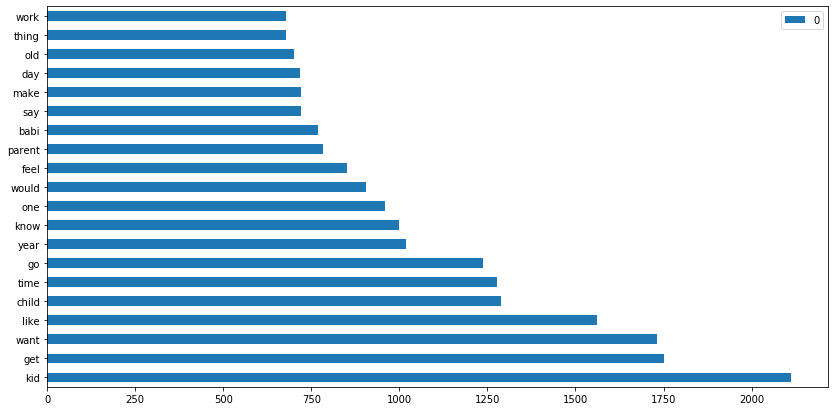

In [48]:
wordslen=train_data_cvec.sum(axis=0)
features=cvec.get_feature_names()
data=pd.DataFrame(np.squeeze(np.asarray(wordslen)),index=features)
data.sort_values(by=0,ascending=False).head(20).plot(kind='barh',figsize=(14,7))

**The top 20 words collected by CountVectoiser in the data are as above.**

## TfidfVectorizer path

Term Frequency-Inverse Document Frequency (TF-IDF) tokenize documents and highlight words that are more rare. Scores assigned to each word, with rarer words more weight. This return encoded document vectors which will be fed through the models.

### Tokenize Data

In [49]:
tvec = TfidfVectorizer() #instantiate model

In [50]:
tvec.fit(clean_train) # fit model to training data first

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [51]:
train_data_tvec=tvec.transform(clean_train) #transform clean data
test_data_tvec=tvec.transform(clean_test) #transform test data
train_data_tvec=train_data_tvec.todense() # The matrix is sparse. Sparse matrices can cause problems with regards to space and time complexity. Todense() helps store the data more efficiently
test_data_tvec=test_data_tvec.todense() #Todense() helps store the data more efficiently

### Cross Validation

In [52]:
print(cross_val_score(lr,train_data_tvec,y_train,cv=10).mean())
print(cross_val_score(nb,train_data_tvec,y_train,cv=10).mean())
print(cross_val_score(gb,train_data_tvec,y_train,cv=10).mean())
print(cross_val_score(ada,train_data_tvec,y_train,cv=10).mean())

/Users/jiaxing/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jiaxing/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jiaxing/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jiaxing/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jiaxing/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed

0.9124134232986283
0.9045771333243963
0.7372603780329774
0.8571660187378048


**Logresstic regression produces the best accuracy. This model will be further scored on the training data and testing data.**

In [53]:
lr.fit(train_data_tvec,y_train) 
lr.score(train_data_tvec,y_train)

/Users/jiaxing/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.9791816223977028

In [54]:
lr.score(test_data_tvec,y_test)

0.9195979899497487

**The accuracy is high but the model is overfit to the training data. Accuracy is similar but lower than first model. Girdsearch to be performed to find the optimal parameters.**

### Gridsearch

In [55]:
pipe_tvec = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('lr', LogisticRegression()),
])
pipe_params = {
    'tvec__max_features': [2500, 3000, 4000, 4500],
    'tvec__ngram_range': [(1,1), (1,2), (1,3)],
    'lr__C': np.linspace(3.5, 4.5, 5)
}
gs_tvec = GridSearchCV(pipe_tvec, param_grid=pipe_params, cv=10, n_jobs=-1)

In [56]:
gs_tvec.fit(clean_train,y_train)

/Users/jiaxing/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('tvec',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                         

In [57]:
print(gs_tvec.best_params_)
print(gs_tvec.best_score_)

{'lr__C': 3.5, 'tvec__max_features': 3000, 'tvec__ngram_range': (1, 2)}
0.9203158650394831


### Final Model with TF-IDF

In [58]:
tvec = TfidfVectorizer(max_features=3000, ngram_range=(1,2)) #instantiate new model

In [59]:
tvec.fit(clean_train) # fit model to training data first

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=3000,
                min_df=1, ngram_range=(1, 2), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [60]:
train_data_tvec=tvec.transform(clean_train) #transform clean data
test_data_tvec=tvec.transform(clean_test) #transform test data
train_data_tvec=train_data_tvec.todense() # The matrix is sparse. Sparse matrices can cause problems with regards to space and time complexity.
test_data_tvec=test_data_tvec.todense() #Todense() helps store the data more efficiently

In [61]:
lr_tvec=LogisticRegression(C=3.5)
lr_tvec.fit(train_data_tvec,y_train) 
lr_tvec.score(train_data_tvec,y_train)

/Users/jiaxing/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.9928212491026561

In [62]:
lr_tvec.score(test_data_tvec,y_test)

0.9413735343383585

In [63]:
tn, fp, fn, tp =confusion_matrix(y_test, 
                 lr_tvec.predict(test_data_tvec)).ravel()

In [64]:
print(classification_report(y_test, lr_tvec.predict(test_data_tvec)))

              precision    recall  f1-score   support

           0       0.95      0.93      0.94       299
           1       0.93      0.95      0.94       298

    accuracy                           0.94       597
   macro avg       0.94      0.94      0.94       597
weighted avg       0.94      0.94      0.94       597



In [65]:
print(f'Accuracy = {round((tp + tn) /(tn+ fp+ fn+ tp),3)}')
print(f'Misclassification Rate = {round((fp + fn) /(tn+ fp+ fn+ tp),3)}')
print(f'Sensitivity = {round(tp /(fn+ tp),3)}')
print(f'Specificity = {round(tn /(fp+ tn),3)}')
print(f'Precision = {round(tp /(fp+ tp),3)}')

Accuracy = 0.941
Misclassification Rate = 0.059
Sensitivity = 0.95
Specificity = 0.933
Precision = 0.934


##### 5.9% of the posts are misclassified and 94.1% of the post are correctly labelled. Due to the nature of the posts, False positive and False negative are equally bad. It may invite unneccesary comments.

### Receiver Operating Characteristic Curve

In [66]:
pred_proba_tvec = [i[1] for i in lr_tvec.predict_proba(test_data_tvec)]

pred_df_tvec = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba_tvec})

In [ ]:
print(roc_auc_score(y_test,pred_proba_tvec)) ## Area Under the ROC Curve

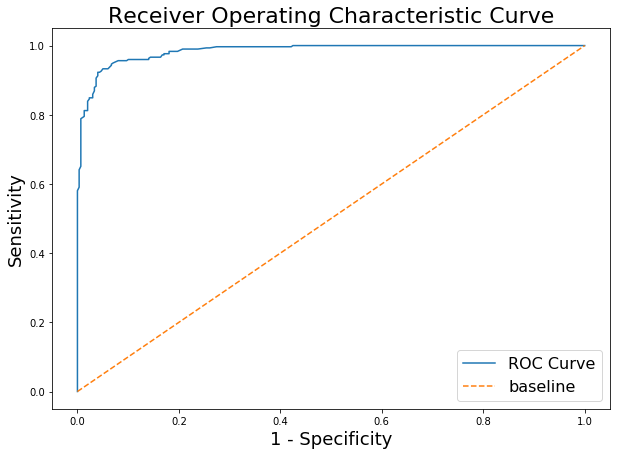

In [67]:
# Create figure.
plt.figure(figsize = (10,7))

# Create threshold values.
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)

# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values_lr_tvec = [TPR(pred_df_tvec, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values_lr_tvec = [FPR(pred_df_tvec, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values_lr_tvec, # False Positive Rate on X-axis
         tpr_values_lr_tvec, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title('Receiver Operating Characteristic Curve', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16);

**We can see that the model is performing better than the baseline model.**

## HashingVectorizer path

HashingVectorizer hash words, converts them to integars then tokenize and encode documents as needed.

### Tokenize Data

In [68]:
hvec =HashingVectorizer(alternate_sign=False)# instantiate model

In [69]:
hvec.fit(clean_train)

HashingVectorizer(alternate_sign=False, analyzer='word', binary=False,
                  decode_error='strict', dtype=<class 'numpy.float64'>,
                  encoding='utf-8', input='content', lowercase=True,
                  n_features=1048576, ngram_range=(1, 1), norm='l2',
                  preprocessor=None, stop_words=None, strip_accents=None,
                  token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None)

In [70]:
train_data_hvec=hvec.transform(clean_train)
test_data_hvec=hvec.transform(clean_test)
train_data_hvec=train_data_hvec.todense()
test_data_hvec=test_data_hvec.todense()

### Cross Validation

In [233]:
print(cross_val_score(lr,train_data_hvec,y_train,cv=10).mean())
print(cross_val_score(nb,train_data_hvec,y_train,cv=10).mean())
print(cross_val_score(gb,train_data_hvec,y_train,cv=10).mean())
print(cross_val_score(ada,train_data_hvec,y_train,cv=10).mean())

/Users/jiaxing/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jiaxing/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jiaxing/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jiaxing/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jiaxing/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed

0.9023515349211315
0.9060055558038043
0.7086120916931051
0.852854536246779


**MultinomialNB gives the best accuracy. Hence we will deploy MultinomialNB to further test on our train and test data.**

In [72]:
nb.fit(train_data_hvec,y_train)
nb.score(train_data_hvec,y_train)

0.9490308686288585

In [96]:
nb.score(test_data_hvec,y_test)

0.9179229480737019

**The accuracy is high but the model is overfit to the training data. Accuracy is similar but lower than first model.**

### Gridsearch

In [97]:
pipe_hvec = Pipeline([
    ('hvec', HashingVectorizer(alternate_sign=False)),
    ('nb', MultinomialNB()),
])
pipe_params = {
    'hvec__n_features': [5000, 5500, 6000, 6500, 7000, ],
    'hvec__ngram_range': [(1,1), (1,2), (1,3)],
    'nb__alpha':np.linspace(0.1, 0.15, 5)
}
gs_hvec = GridSearchCV(pipe_hvec, param_grid=pipe_params, cv=10, n_jobs=-1)

In [98]:
gs_hvec.fit(clean_train,y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('hvec',
                                        HashingVectorizer(alternate_sign=False,
                                                          analyzer='word',
                                                          binary=False,
                                                          decode_error='strict',
                                                          dtype=<class 'numpy.float64'>,
                                                          encoding='utf-8',
                                                          input='content',
                                                          lowercase=True,
                                                          n_features=1048576,
                                                          ngram_range=(1, 1),
                                                          norm='l2',
       

In [99]:
print(gs_hvec.best_params_)
print(gs_hvec.best_score_)

{'hvec__n_features': 6500, 'hvec__ngram_range': (1, 1), 'nb__alpha': 0.1}
0.914572864321608


### Final Model with HashingVectorizer

In [100]:
hvec =HashingVectorizer(alternate_sign=False, n_features=6500, ngram_range=(1,1) )# instantiate model

In [101]:
hvec.fit(clean_train)

HashingVectorizer(alternate_sign=False, analyzer='word', binary=False,
                  decode_error='strict', dtype=<class 'numpy.float64'>,
                  encoding='utf-8', input='content', lowercase=True,
                  n_features=6500, ngram_range=(1, 1), norm='l2',
                  preprocessor=None, stop_words=None, strip_accents=None,
                  token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None)

In [102]:
train_data_hvec=hvec.transform(clean_train)
test_data_hvec=hvec.transform(clean_test)
train_data_hvec=train_data_hvec.todense()
test_data_hvec=test_data_hvec.todense()

In [103]:
nb_hvec = MultinomialNB(alpha=0.1)
nb_hvec.fit(train_data_hvec,y_train)
nb_hvec.score(train_data_hvec,y_train)

0.9662598707824839

In [104]:
nb_hvec.score(test_data_hvec,y_test)

0.9279731993299832

In [105]:
tn, fp, fn, tp=confusion_matrix(y_test, 
                 nb_hvec.predict(test_data_hvec)).ravel()

In [106]:
print(classification_report(y_test,nb_hvec.predict(test_data_hvec)))

              precision    recall  f1-score   support

           0       0.93      0.92      0.93       299
           1       0.92      0.93      0.93       298

    accuracy                           0.93       597
   macro avg       0.93      0.93      0.93       597
weighted avg       0.93      0.93      0.93       597



In [107]:
print(f'Accuracy = {round((tp + tn) /(tn+ fp+ fn+ tp),3)}')
print(f'Misclassification Rate = {round((fp + fn) /(tn+ fp+ fn+ tp),3)}')
print(f'Sensitivity = {round(tp /(fn+ tp),3)}')
print(f'Specificity = {round(tn /(fp+ tn),3)}')
print(f'Precision = {round(tp /(fp+ tp),3)}')

Accuracy = 0.928
Misclassification Rate = 0.072
Sensitivity = 0.933
Specificity = 0.923
Precision = 0.924


##### 7.2% of the posts are misclassified and 92.8% of the post are correctly labelled. Due to the nature of the posts, False positive and False negative are equally bad. It may invite unneccesary comments.

### Receiver Operating Characteristic Curve

In [108]:
pred_proba_hvec = [i[1] for i in nb_hvec.predict_proba(test_data_hvec)]

pred_df_hvec = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba_hvec})

In [109]:
print(roc_auc_score(y_test,pred_proba_hvec)) ## Area Under the ROC Curve

0.9757356737222509


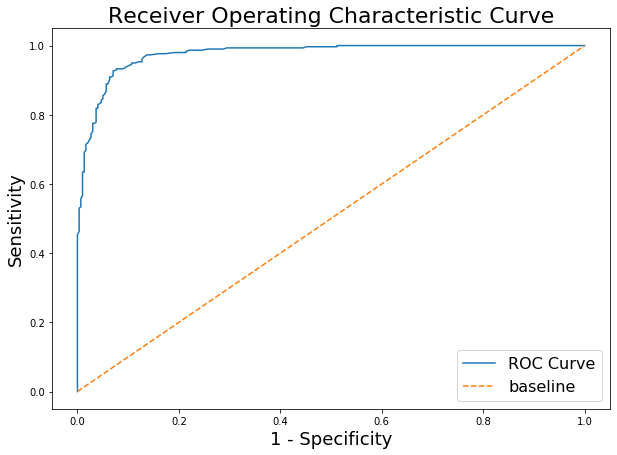

In [110]:
# Create figure.
plt.figure(figsize = (10,7))

# Create threshold values.
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)

# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values_nb_hvec = [TPR(pred_df_hvec, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values_nb_hvec = [FPR(pred_df_hvec, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values_nb_hvec, # False Positive Rate on X-axis
         tpr_values_nb_hvec, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title('Receiver Operating Characteristic Curve', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16);

We can see that the model is performing better than the baseline model. 

## Voting Model

**Finally I will like to use the voting classifier to see if it will give a better preditcion. As GaussianNB model have not been peforming as compared to the other models. I will only use MultinomialNB, LogisticRegression and AdaBoostClassifier in the voting classifer.**

### CountVector VotingClassifier

##### As multinomial classifier performs the best with countvector, we will instantiate the model with the optimal alpha for multinomial classifier.

In [111]:
vote_cvec = VotingClassifier([('nb', MultinomialNB(alpha=2.111111111111111)),
                         ('lr', LogisticRegression()),
                         ('ada', AdaBoostClassifier()),
                        ],voting='soft')

In [112]:
vote_cvec.fit(train_data_cvec,y_train)
print(vote_cvec.score(train_data_cvec,y_train))
print(vote_cvec.score(test_data_cvec,y_test))

/Users/jiaxing/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.9727207465900933
0.9363484087102177


### TF-IDF VotingClassifier

##### As LogisticRegression classifier performs the best with TF-IDF, we will instantiate the model with the optimal alpha for multinomial classifier.

In [113]:
vote_tvec = VotingClassifier([('nb', MultinomialNB()),
                         ('lr', LogisticRegression(C=3.5)),
                         ('ada', AdaBoostClassifier()),
                        ],voting='soft')

In [114]:
vote_tvec.fit(train_data_tvec,y_train)
print(vote_tvec.score(train_data_tvec,y_train))
print(vote_tvec.score(test_data_tvec,y_test))

/Users/jiaxing/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.9842067480258435
0.9363484087102177


### HashingVector VotingClassifier

##### As multinomial classifier performs the best with Hashingvector, we will instantiate the model with the optimal alpha for multinomial classifier.

In [115]:
vote_hvec = VotingClassifier([('nb', MultinomialNB(alpha=0.1)),
                         ('lr', LogisticRegression()),
                         ('ada', AdaBoostClassifier()),
                        ],voting='soft')

In [116]:
vote_hvec.fit(train_data_hvec,y_train)
print(vote_hvec.score(train_data_hvec,y_train))
print(vote_hvec.score(test_data_hvec,y_test))

/Users/jiaxing/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.9662598707824839
0.9179229480737019


**Voting classifer with tvec data produces the highest accuracy.**

In [117]:
tn, fp, fn, tp=confusion_matrix(y_test, 
                 vote_tvec.predict(test_data_tvec)).ravel()

In [118]:
print(classification_report(y_test,vote_tvec.predict(test_data_tvec)))

              precision    recall  f1-score   support

           0       0.94      0.93      0.94       299
           1       0.93      0.94      0.94       298

    accuracy                           0.94       597
   macro avg       0.94      0.94      0.94       597
weighted avg       0.94      0.94      0.94       597



In [119]:
print(f'Accuracy = {round((tp + tn) /(tn+ fp+ fn+ tp),3)}')
print(f'Misclassification Rate = {round((fp + fn) /(tn+ fp+ fn+ tp),3)}')
print(f'Sensitivity = {round(tp /(fn+ tp),3)}')
print(f'Specificity = {round(tn /(fp+ tn),3)}')
print(f'Precision = {round(tp /(fp+ tp),3)}')

Accuracy = 0.936
Misclassification Rate = 0.064
Sensitivity = 0.943
Specificity = 0.93
Precision = 0.93


##### 6.4% of the posts are misclassified and 93.6% of the post are correctly labelled. False positive and False negative are equally bad and we need to reduce this.

### Receiver Operating Characteristic Curve

In [120]:
pred_proba_vote = [i[1] for i in vote_tvec.predict_proba(test_data_tvec)]

pred_df_vote = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba_vote})

In [121]:
print(roc_auc_score(y_test,pred_proba_vote)) ## Area Under the ROC Curve

0.9847478171084825


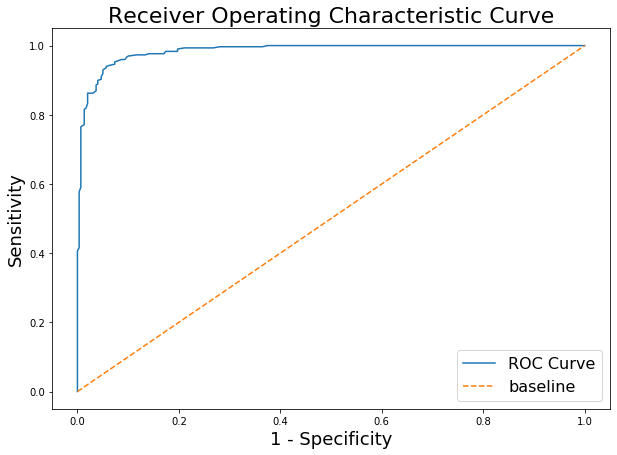

In [122]:
# Create figure.
plt.figure(figsize = (10,7))

# Create threshold values.
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)

# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values_vote = [TPR(pred_df_vote, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values_vote = [FPR(pred_df_vote, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values_vote, # False Positive Rate on X-axis
         tpr_values_vote, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title('Receiver Operating Characteristic Curve', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16);

We can see that the model performs better than our baseline model.

## Comparing all the models

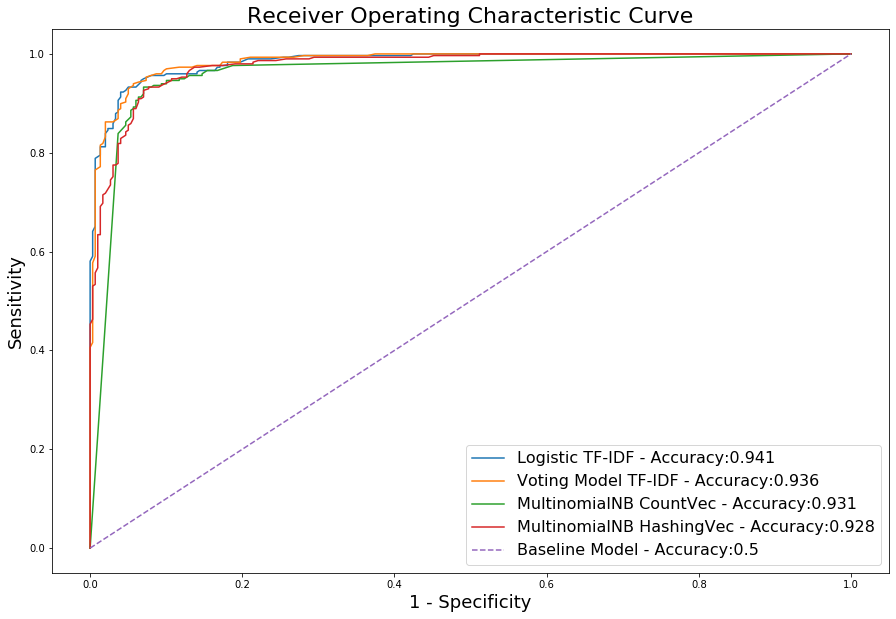

In [123]:
# Create figure.
plt.figure(figsize = (15,10))

# Create threshold values.
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)

# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values_vote = [TPR(pred_df_vote, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values_vote = [FPR(pred_df_vote, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values_lr_tvec, # False Positive Rate on X-axis
         tpr_values_lr_tvec, # True Positive Rate on Y-axis
         label='Logistic TF-IDF - Accuracy:0.941')
plt.plot(fpr_values_vote, # False Positive Rate on X-axis
         tpr_values_vote, # True Positive Rate on Y-axis
         label='Voting Model TF-IDF - Accuracy:0.936')
plt.plot(fpr_values_nb_cvec, # False Positive Rate on X-axis
         tpr_values_nb_cvec, # True Positive Rate on Y-axis
         label='MultinomialNB CountVec - Accuracy:0.931')
plt.plot(fpr_values_nb_hvec, # False Positive Rate on X-axis
         tpr_values_nb_hvec, # True Positive Rate on Y-axis
         label='MultinomialNB HashingVec - Accuracy:0.928')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='Baseline Model - Accuracy:0.5',
         linestyle='--')

# Label axes.
plt.title('Receiver Operating Characteristic Curve', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16);

In [229]:
print(f'AUC Score for Logistic TF-IDF: {roc_auc_score(y_test,pred_proba_tvec)}')
print(f'AUC Score for Voting Model TF-IDF: {roc_auc_score(y_test,pred_proba_vote)}')
print(f'AUC Score for MultinomialNB CountVec: {roc_auc_score(y_test,pred_proba_cvec)}')
print(f'AUC Score for MultinomialNB HashingVec: {roc_auc_score(y_test,pred_proba_hvec)}')

AUC Score for Logistic TF-IDF: 0.9844672397925973
AUC Score for Voting Model TF-IDF: 0.9847478171084825
AUC Score for MultinomialNB CountVec: 0.9738950865300442
AUC Score for MultinomialNB HashingVec: 0.9757356737222509


In [235]:
print(f'Accuracy for Logistic TF-IDF: {lr_tvec.score(test_data_tvec,y_test)}')
print(f'Accuracy for Voting Model TF-IDF: {vote_tvec.score(test_data_tvec,y_test)}')
print(f'Accuracy for MultinomialNB CountVec: {nb_cvec.score(test_data_cvec,y_test)}')
print(f'Accuracy for MultinomialNB HashingVec: {nb_hvec.score(test_data_hvec,y_test)}')

Accuracy for Logistic TF-IDF: 0.9413735343383585
Accuracy for Voting Model TF-IDF: 0.9363484087102177
Accuracy for MultinomialNB CountVec: 0.931323283082077
Accuracy for MultinomialNB HashingVec: 0.9279731993299832


**The best model that provides the best accuracy is TF-IDF with Logistic Regression.**

**Using the predictions from the model, I will like to explore which posts are missclassified.**

## Misclassification

In [125]:
# creating new dataframe with predictions and true vale
prediction=pd.DataFrame({'true_values':y_test,'predictions':lr_tvec.predict(test_data_tvec)})

Creating a new dataframe with all the true values VS the predictions and filtering the post which are misclassified.

In [126]:
misclassified_index=prediction[prediction['true_values']!=prediction['predictions']].index #filtering misclassified post

In [236]:
print(f'Number of misclassified post:{len(misclassified_index)}') # Number of misclassified post

Number of misclassified post:35


In [128]:
misclassified=[]
true_values=[]
for x in misclassified_index:
    misclassified.append(df.iloc[x,4])
    true_values.append(df.iloc[x,3])

Creating a new dataframe with all all the misclassified posts only.

In [129]:
misclassified_df=pd.DataFrame({'true_values':true_values,'title+post':misclassified})

In [130]:
pd.set_option('display.max_colwidth', -1)

In [131]:
misclassified_df['true_values'].value_counts(normalize=True)

0    0.571429
1    0.428571
Name: true_values, dtype: float64

**Of all the misclassified post, 57% are childfree posts while 43% are parenting posts. More childfree posts are wrongly predicted**

**Next, I will like to see which features hold the highest coeff which may actually cause the classification.**

In [132]:
#new dataframe with features and coefficients of features.
data_tvec=pd.DataFrame({'Coeff':np.squeeze(np.asarray(lr_tvec.coef_[0])),'features':tvec.get_feature_names()})

Text(0.5, 1.0, 'Top 10 Positive features')

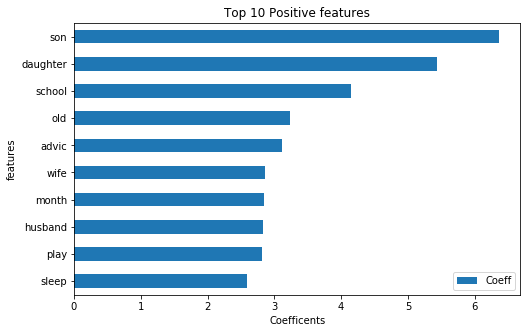

In [252]:
#top 10 positive coeff features
data_tvec.sort_values(by='Coeff').tail(10).plot(kind='barh',x='features',figsize=(8,5))
plt.xlabel('Coefficents')
plt.title('Top 10 Positive features')

**The above shows the top 10 features with the highest positive coefficients.**

Text(0.5, 1.0, 'Top 10 negative features')

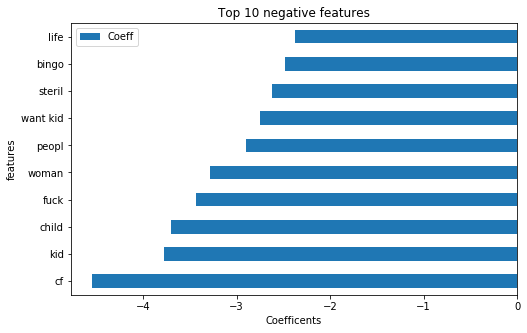

In [253]:
#top 10 negative coeff features
data_tvec.sort_values(by='Coeff').head(10).plot(kind='barh',x='features',figsize=(8,5))
plt.xlabel('Coefficents')
plt.title('Top 10 negative features')

**The above shows the top 10 features with the highest negative coefficients.**

**Next, I will like to see how frequently these words appear in the misclassified posts. I will be generate the top 10 postive and top 10 negative features list**

In [135]:
positive_words=data_tvec.sort_values(by='Coeff').tail(10)['features']

In [136]:
positive_words=[words for words in positive_words]

In [137]:
positive_words #labelling as such as it is positive coefficients

['sleep',
 'play',
 'husband',
 'month',
 'wife',
 'advic',
 'old',
 'school',
 'daughter',
 'son']

In [138]:
negative_words=data_tvec.sort_values(by='Coeff').head(10)['features']

In [139]:
negative_words=[words for words in negative_words]

In [140]:
negative_words #labelling as such as it is negative coefficients

['cf',
 'kid',
 'child',
 'fuck',
 'woman',
 'peopl',
 'want kid',
 'steril',
 'bingo',
 'life']

In [141]:
childfree_post = [] #to store the clean childfree post which are misclassified
parenting_post = [] #to store the clean parenting post which are misclassified

In [142]:
for data in misclassified_df[misclassified_df['true_values']==0]['title+post']:
    # Convert review to words, then append to childfree_post.
    childfree_post.append(review_to_words(data))

for data in misclassified_df[misclassified_df['true_values']==1]['title+post']:
    # Convert review to words, then append to parenting_post.
    parenting_post.append(review_to_words(data))

In [143]:
childfree_wordcount=[] # to store all the words in childfree post which are misclassified
for post in childfree_post:
    childfree_wordcount.extend(post.split())

In [248]:
print(f'Count of words: {len(childfree_wordcount)}')
print(f'Count of positive words: {[word in post for post in childfree_post for word in positive_words].count(True)}')

Count of words: 2897
Count of positive words: 48


**Positive words appears about 48/2897 = 1% of the posts while they are only 10/3000=0.3% of the features. The user's choice of words may have mislead the classifier to categorise it as parenting post, considering the positive coefficent these features holds.**

In [145]:
parenting_wordcount=[] # to store all the words in parenting post which are misclassified
for post in parenting_post:
    parenting_wordcount.extend(post.split())

In [250]:
print(f'Count of words: {len(parenting_wordcount)}')
print(f'Count of positive words: {[word in post for post in parenting_post for word in negative_words].count(True)}')

Count of words: 1466
Count of positive words: 28


**Negative words appears about 28/1466 = 2% of the post while they are only 10/3000=0.3% of the features. The user's choice of words may have mislead the classifier to categorise it as childfree post, considering the negative coefficent these features holds.**

**Below are the misclassified parenting and childfree posts.**

In [147]:
pd.options.display.max_columns

20

In [230]:
misclassified_df[misclassified_df['true_values']==1] # misclassified parenting posts

true_values  \
0   1             
6   1             
7   1             
9   1             
12  1             
15  1             
16  1             
17  1             
18  1             
23  1             
24  1             
25  1             
26  1             
27  1             
32  1             

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

In [232]:
misclassified_df[misclassified_df['true_values']==0] # misclassified childfree posts

true_values  \
1   0             
2   0             
3   0             
4   0             
5   0             
8   0             
10  0             
11  0             
13  0             
14  0             
19  0             
20  0             
21  0             
22  0             
28  0             
29  0             
30  0             
31  0             
33  0             
34  0             

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

# Conclusion

We had trained a classifier model - Logistic Regression and achieved an accuracy score of 94.1%. However there remains a misclassification rate of 5.9%. 

False positive and false negative accounts for the 5.9% with a total of 35 posts. As mentioned earlier, these are both equally bad. A parenting post usually highlights the struggles with raising the child and support from the community is much appreciated. If such post are misclassified into childfree subreddit, it will not garner the support, but instead it will draw criticism from the wrong community and may lead to cyberbulling. This will ultimately affect user experience in the reddit website.

While machine learning models are able to predict, with great accuracy, the subreddit for the post to be in, we are not able to control users' choice of words(which greatly affect our accuracy). 

For this case, perhaps other NLP techiques(eg, sentimental anaylsis) have to be used in conjuction to improve the accuracy of the classification.